In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import lmfit
from tqdm.auto import tqdm
import pickle
import joblib
from BRmodel import BRModel
# import required packages
import os
import scipy.io as sio
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
from pymcmcstat import mcmcplot as mcp
import pymcmcstat

import approxbayescomp as abc

import pymc as pm
import arviz as az

print(pymcmcstat.__version__)
np.seterr(over='ignore')

import pytensor
import pytensor.tensor as pt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


1.9.1


# DATA

In [2]:
data = pd.read_csv('prepared_wave.csv')
data['0-14'] = data['A(H1N1)pdm09_0-14'] + data['A(H3N2)_0-14'] + data['B_0-14']
data['15 и ст.'] = data['A(H1N1)pdm09_15 и ст.'] + data['A(H3N2)_15 и ст.'] + data['B_15 и ст.']
data['CONFIRMED'] = data['0-14'] + data['15 и ст.']

In [3]:
print(data.shape)
data.head()

(22, 21)


,Unnamed: 0,index,Год,Неделя,A(H1N1)pdm09_15 и ст.,A(H3N2)_15 и ст.,B_15 и ст.,Население 15 и ст.,A(H1N1)pdm09_15 и ст._rel,A(H3N2)_15 и ст._rel,...,A(H1N1)pdm09_0-14,A(H1N1)pdm09_0-14_rel,Население 0-14,A(H3N2)_0-14,A(H3N2)_0-14_rel,B_0-14,B_0-14_rel,0-14,15 и ст.,CONFIRMED
0,NaN,156,2013,1,0,0,0,4374156,0.000000,0.000000,...,0,0.000000,579063,0,0.000000,0,0.000000,0,0,0
1,NaN,157,2013,2,318,159,318,4374156,0.072700,0.036350,...,385,2.355146,579063,192,1.176072,385,2.355146,962,795,1757
2,NaN,158,2013,3,1465,1046,0,4374156,0.334922,0.239132,...,1628,9.505731,579063,1163,6.792017,0,0.000000,2791,2511,5302
3,NaN,159,2013,4,2181,727,242,4374156,0.498610,0.166203,...,2594,14.933692,579063,865,4.981166,288,1.658063,3747,3150,6897
4,NaN,160,2013,5,4715,1275,687,4374156,1.077922,0.291485,...,5988,34.003563,579063,1620,9.198878,873,4.956979,8481,6677,15158


In [4]:
data.columns

Index(['Unnamed: 0', 'index', 'Год', 'Неделя', 'A(H1N1)pdm09_15 и ст.',
       'A(H3N2)_15 и ст.', 'B_15 и ст.', 'Население 15 и ст.',
       'A(H1N1)pdm09_15 и ст._rel', 'A(H3N2)_15 и ст._rel', 'B_15 и ст._rel',
       'A(H1N1)pdm09_0-14', 'A(H1N1)pdm09_0-14_rel', 'Население 0-14',
       'A(H3N2)_0-14', 'A(H3N2)_0-14_rel', 'B_0-14', 'B_0-14_rel', '0-14',
       '15 и ст.', 'CONFIRMED'],
      dtype='object')

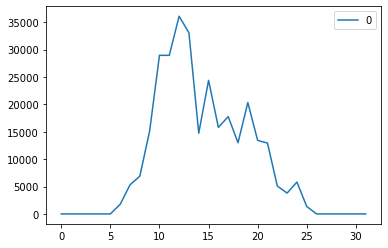

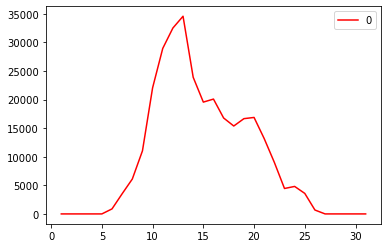

In [5]:
R = np.concatenate((np.zeros(5),data['CONFIRMED']))
R = np.concatenate((R, np.zeros(5)))
R = pd.DataFrame(R)
rolling = R.rolling(window=2, center = True)
rolling_mean = rolling.mean()
# print(rolling_mean.head(10))
# plot original and transformed dataset
R.plot()
rolling_mean.plot(color='red')
plt.show()

<AxesSubplot:>

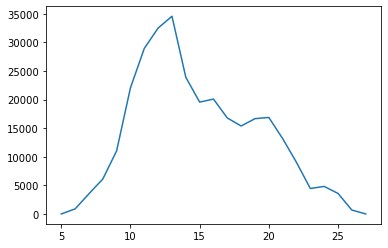

In [47]:
obsData = rolling_mean[5:28][0]
obsData.plot()

# MCMC

In [48]:
def model(args):
    mu, alpha, beta, I0 = args
    pop = 4581854.0
    
    I0 /= pop
    m = BRModel([[6.528]], pop, mu, 'total', '', '')
    exposed_list, lam_list, a = [I0], [beta], [alpha]
    m.set_attributes()
    m.init_simul_params(exposed_list, lam_list, a)
    m.set_attributes()

    Y, population_immunity, rho, r0, rt = m.make_simulation()
    Y = Y[0][0]
    #ma = max(Y)
    #ind_ma = int(np.linspace(0, 1800, 1801)[Y==ma][0])
    return Y

In [49]:
mu, alpha, beta, I0 = optimal_parameters
pop = 4581854.0

T = len(obsData)

m = BRModel([[6.528]], pop, mu, 'total', '', '')
exposed_list, lam_list, a = [I0], [beta], [alpha]
m.set_attributes()
m.init_simul_params(exposed_list, lam_list, a)
m.set_attributes()

Y, population_immunity, rho, r0, rt = m.make_simulation()
Y = Y[0][0]

In [50]:
y = model(optimal_parameters)
y

array([1., 0., 0., ..., 0., 0., 0.])

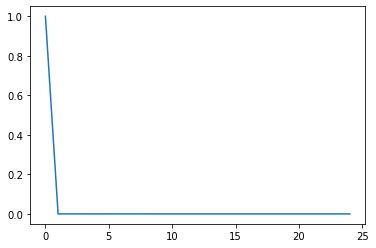

In [51]:
plt.plot(y[:25])

In [52]:
optimal_parameters

[0.9092460318123954,
 0.001802514427547769,
 904.9228853554217,
 0.2882931865945249]

In [76]:
tx = np.arange(len(obsData))
ty = np.array(obsData)
    
# Build a loss function (sum of squares)
def covid_ss(theta, ty):
    ymodel = np.array(model_resid(theta))
    res = ymodel - ty
    ss = (res**2).sum(axis=0)
    return ss  

def model_resid(args):
    mu, alpha, beta, I0 = args
    pop = 4581854.0

    T = len(ty)

    m = BRModel([[6.528]], pop, mu, 'total', '', '')
    exposed_list, lam_list, a = [I0], [beta], [alpha]
    m.set_attributes()
    m.init_simul_params(exposed_list, lam_list, a)
    m.set_attributes()

    Y, population_immunity, rho, r0, rt = m.make_simulation()
    Y = Y[0][0]

    #return Y#[60:60+T]
    # ищем наиболее подходящий для реальных данных кусок предсказаний
    scop = float('-inf')
    out = Y[:T]

    for j in range(200):
        R = max(r2_score(obsData,Y[j:j+T]), scop)
        if R!=scop:
            scop = R
            out = Y[j:j+T]
    return out

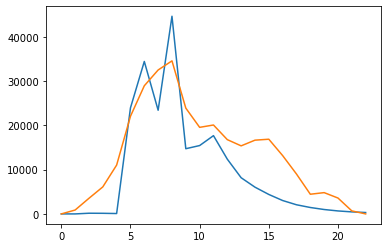

In [78]:
plt.plot(model_resid(optimal_parameters))
plt.plot(ty)

In [79]:
covid_ss(optimal_parameters, ty)

1014804609.995051

In [89]:
np.array(model_resid(optimal_parameters)) - ty

array([     0.        ,   -878.5       ,  -3374.66332493,  -5960.32633617,
       -10942.54793954,   1895.6846282 ,   5489.57012978,  -9088.77827719,
        10075.8499417 ,  -9168.62749933,  -4112.01593894,  -2404.7993046 ,
        -4407.19068742,  -7200.01332219, -10614.06810442, -12473.01862299,
       -10144.94940755,  -6943.0020568 ,  -2996.07587243,  -3811.78873792,
        -2913.58281475,   -221.86699307,    314.18939953])

In [90]:
# Build a loss function (sum of squares)
def covid_ss(theta, data):
    ymodel = np.array(model_resid(theta))
    res = ymodel - ty#data.ydata[0]
    ss = (res**2).sum(axis=0)
    return ss  

In [94]:
# initialize MCMC object
mcstat = MCMC()
# initialize data structure 
mcstat.data.add_data_set(x=tx,
                         y=ty,
                         user_defined_object=tx)

init = {'mu': 0.9092460318123954,
 'a': 0.001802514427547769,
 'beta': 904.9228853554217,
 'I0': 0.2882931865945249}

# initialize MCMC object
mcstat = MCMC()
# initialize data structure 
# tx corresponds to the days, and ty to the active cases
mcstat.data.add_data_set(x=tx, # 0,1,2,3,4,
                         y=ty, # 0, 875.5, ...
                         user_defined_object=tx)

# add model parameters
# Intially population o SPB is considered as 10000000 and all the intial parameters for SIERD model are defined
mcstat.parameters.add_model_parameter(name='mu', theta0=init['mu'], minimum=0, maximum = 1)
mcstat.parameters.add_model_parameter(name='alpha', theta0=init['a'], minimum=0, maximum=1)
mcstat.parameters.add_model_parameter(name='beta', theta0=init['beta'], minimum=500, maximum=1500)
mcstat.parameters.add_model_parameter(name='I0', theta0=init['I0'], minimum=0, maximum=1)

# simulation_options and model settings
# nsimu - Number of parameter samples to simulate
mcstat.simulation_options.define_simulation_options(nsimu=1e3, updatesigma=True)
mcstat.model_settings.define_model_settings(
    sos_function=covid_ss)

# Run simulation
mcstat.run_simulation()
# Rerun starting from results of previous run
mcstat.simulation_options.nsimu = int(1.0e3)
mcstat.run_simulation(use_previous_results=True)



Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.91 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
     alpha:  1.80e-03 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
      beta:    904.92 [   500.00,   1500.00] N( 0.00e+00,      inf)
        I0:      0.29 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 1001 of 1000 complete in 225.7 sec
Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
        mu:      0.92 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
     alpha:  2.05e-03 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
      beta:   1043.99 [   500.00,   1500.00] N( 0.00e+00,      inf)
        I0:      0.27 [ 0.00e+00,      1.00] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 1000 of 1000 complete in 195.4 sec

In [95]:
# extract info from results
results = mcstat.simulation_results.results
burnin = int(results['nsimu']/2)
chain = results['chain'][burnin:, :]
s2chain = results['s2chain'][burnin:, :]
names = results['names'] # parameter names

# display chain stats
mcstat.chainstats(chain, results)



------------------------------
      name:      mean       std    MC_err       tau    geweke
        mu:      0.70      0.23      0.05    204.87      0.50
     alpha:  2.30e-03  5.90e-04  1.06e-04     73.26      0.76
      beta:   1002.94    112.80     19.72     58.84      0.89
        I0:      0.19      0.18      0.04    188.19      0.49
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 3.80%
Stage 2: 18.50%
Net    : 22.30% -> 223/1000
---------------
Chain provided:
Net    : 33.02% -> 495/1499
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


In [99]:
optimal_parameters

[0.9092460318123954,
 0.001802514427547769,
 904.9228853554217,
 0.2882931865945249]

In [108]:
import sys
np.savetxt(sys.stdout, results['theta'], '%5.4f')

0.2281
0.0023
1110.5049
0.0272


In [122]:
np.savetxt(sys.stdout, np.mean(chain, 0), '%5.4f') #  point estimate of the model parameters

0.6978
0.0023
1002.9369
0.1881


In [109]:
# Build a loss function (sum of squares)
def ss(theta, ty):
    ymodel = np.array(model_resid(theta))
    res = ymodel - ty
    ss = (res**2).sum(axis=0)
    return ss  

ss(optimal_parameters, ty), ss( results['theta'], ty)

(1014804609.995051, 1165067279.9174352)

[2.28084881e-01 2.27296711e-03 1.11050489e+03 2.71959954e-02]


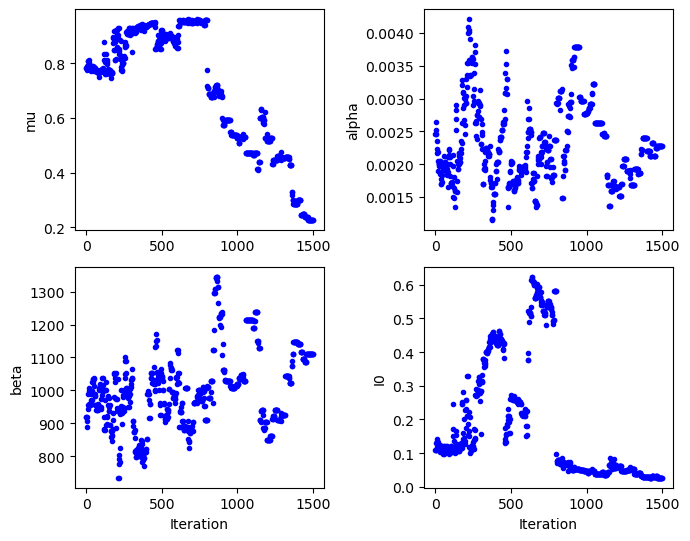

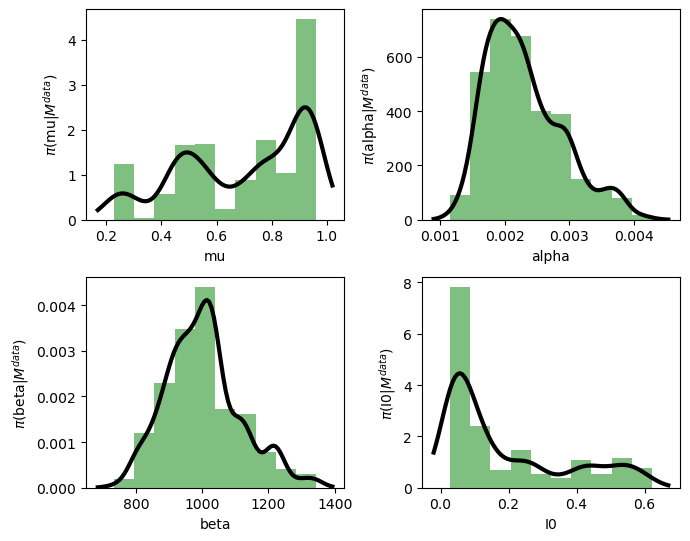

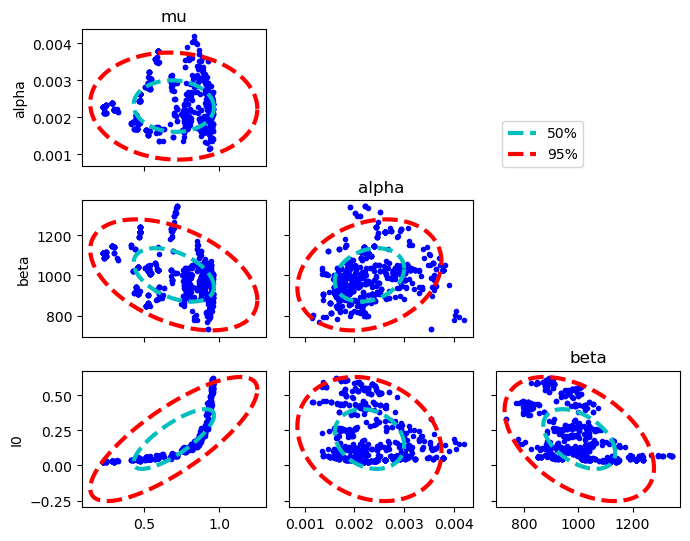

In [120]:
settings = dict(
    fig=dict(figsize=(7, 6))
)
# plot chain panel
mcp.plot_chain_panel(chain, names, settings)#=dict(add_pm2std=True,
                                               #  mean=dict(color='black'))) # the sampling history of the chains.
# plot density panel
# uses a Kernel Density Estimator (KDE) to generate a probability distribution from the sample points in the chain.
mcp.plot_density_panel(chain, names, hist_on=True,
                       settings = dict(hist=dict(color='g',alpha=0.5),
                                                     fig=dict(figsize=(7, 6))
                                                    )
                      )

settings = dict(add_5095_contours=True, plot_95=dict(color='r',linewidth=3),
                plot_50=dict(color='c',linewidth=3),
                add_legend=True, legend=dict(loc='upper right',fontsize=10,bbox_to_anchor=(0.85, 0.75)),
                fig=dict(figsize=(7,6)))

# pairwise correlation
f = mcp.plot_pairwise_correlation_panel(chain, names, settings)


print(results['theta'])

In [127]:
def model_resid(data, args):
    mu, alpha, beta, I0 = args
    pop = 4581854.0

    T = len(ty)

    m = BRModel([[6.528]], pop, mu, 'total', '', '')
    exposed_list, lam_list, a = [I0], [beta], [alpha]
    m.set_attributes()
    m.init_simul_params(exposed_list, lam_list, a)
    m.set_attributes()

    Y, population_immunity, rho, r0, rt = m.make_simulation()
    Y = Y[0][0]

    #return Y#[60:60+T]
    # ищем наиболее подходящий для реальных данных кусок предсказаний
    scop = float('-inf')
    out = Y[:T]

    for j in range(200):
        R = max(r2_score(obsData,Y[j:j+T]), scop)
        if R!=scop:
            scop = R
            out = Y[j:j+T]
    return out

Generating credible/prediction intervals:


Interval generation complete



C:\Users\user\AppData\Local\Temp\ipykernel_10428\1291950458.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xlabel('x (mg/L COD)', Fontsize=20)
C:\Users\user\AppData\Local\Temp\ipykernel_10428\1291950458.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(Fontsize=20)
C:\Users\user\AppData\Local\Temp\ipykernel_10428\1291950458.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('y (1/h)', Fontsize=20)
C:\Users\user\AppData\Local\Temp\ipykernel_10428\1291950458.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.yticks(Fontsize=20)
C:\Users\user\AppData\Local\Temp\ipykernel_10428\1291950458.py:14

Text(0.5, 1.0, 'Predictive envelopes of the model')

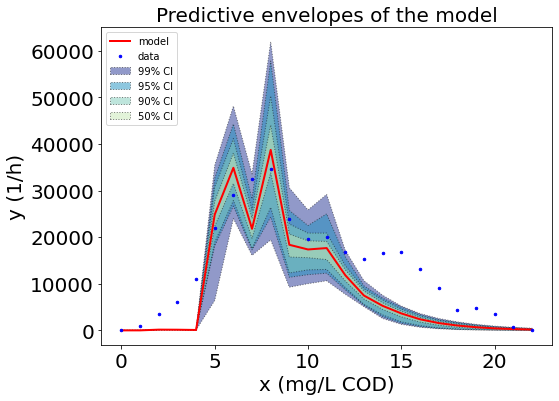

In [128]:
mcstat.PI.setup_prediction_interval_calculation(
    results=results,
    data=mcstat.data,
    modelfunction=model_resid)

mcstat.PI.generate_prediction_intervals(
    nsample=500,
    calc_pred_int=False)

# plot prediction intervals
mcstat.PI.plot_prediction_intervals(adddata=True)
plt.xlabel('x (mg/L COD)', Fontsize=20)
plt.xticks(Fontsize=20)
plt.ylabel('y (1/h)', Fontsize=20)
plt.yticks(Fontsize=20)
plt.title('Predictive envelopes of the model', Fontsize=20)

In [10]:
def mh(df):
    tx = np.arange(len(df))
    ty = np.array(obsData)
    
    # Build a loss function (sum of squares)
    def covid_ss(theta, data):
        ymodel = np.array(model_resid(theta))
        res = ymodel - ty
        ss = (res**2).sum(axis=0)
        return ss  

    def model_resid(args):
        mu, alpha, beta, I0 = args
        pop = 4581854.0

        T = len(ty)
        
        m = BRModel([[6.528]], pop, mu, 'total', '', '')
        exposed_list, lam_list, a = [I0], [beta], [alpha]
        m.set_attributes()
        m.init_simul_params(exposed_list, lam_list, a)
        m.set_attributes()
    
        Y, population_immunity, rho, r0, rt = m.make_simulation()
        Y = Y[0][0]

        return Y[60:60+T]
        
        scop = float('-inf')
        out = Y[:T]
        
        for j in range(200):
            R = max(r2_score(obsData,Y[j:j+T]), scop)
            if R!=scop:
                scop = R
                out = Y[j:j+T]
        return out

    
    # tx corresponds to the days, and ty to the active cases
    init = {'mu': 0.9092460318123954,
     'a': 0.001802514427547769,
     'beta': 904.9228853554217,
     'I0': 0.2882931865945249}
    
    # initialize MCMC object
    mcstat = MCMC()
    # initialize data structure 
    mcstat.data.add_data_set(x=tx,
                             y=ty,
                             user_defined_object=tx)
    # initialize parameter array
    # add model parameters

    # initialize parameter array
    # add model parameters
    # Intially population o SPB is considered as 10000000 and all the intial parameters for SIERD model are defined
    mcstat.parameters.add_model_parameter(name='mu', theta0=init['mu'], minimum=0, maximum = 1)
    mcstat.parameters.add_model_parameter(name='alpha', theta0=init['a'], minimum=0, maximum=1)
    mcstat.parameters.add_model_parameter(name='beta', theta0=init['beta'], minimum=500, maximum=1500)
    mcstat.parameters.add_model_parameter(name='I0', theta0=init['I0'], minimum=0, maximum=1)






    # Generate options
    mcstat.simulation_options.define_simulation_options(nsimu=3e3, updatesigma=True)


    mcstat.model_settings.define_model_settings(
        sos_function=covid_ss)

    # Run simulation
    mcstat.run_simulation()
    # Rerun starting from results of previous run
    mcstat.simulation_options.nsimu = int(1.0e4)
    mcstat.run_simulation(use_previous_results=True)
    
    # extract info from results
    results = mcstat.simulation_results.results
    burnin = int(results['nsimu']/2)
    chain = results['chain'][burnin:, :]
    s2chain = results['s2chain'][burnin:, :]
    names = results['names'] # parameter names

    # display chain stats
    mcstat.chainstats(chain, results)

    settings = dict(
        fig=dict(figsize=(7, 6))
    )
    # plot chain panel
    mcp.plot_chain_panel(chain, names, settings)
    # plot density panel
    mcp.plot_density_panel(chain, names, settings)
    # pairwise correlation
    f = mcp.plot_pairwise_correlation_panel(chain, names, settings)

    
    return results['theta']

In [29]:
def metrics_and_plot(df, optimal_parameters):
    args = optimal_parameters
    N = 4581854.0

    def model_resid(args):
        mu, alpha, beta, I0 = args
        pop = 4581854.0

        T = len(obsData)
        
        m = BRModel([[6.528]], pop, mu, 'total', '', '')
        exposed_list, lam_list, a = [I0], [beta], [alpha]
        m.set_attributes()
        m.init_simul_params(exposed_list, lam_list, a)
        m.set_attributes()
    
        Y, population_immunity, rho, r0, rt = m.make_simulation()
        Y = Y[0][0]

        return Y
        
        scop = float('-inf')
        out = Y[:T]
        
        for j in range(200):
            R = max(r2_score(obsData,Y[j:j+T]), scop)
            if R!=scop:
                scop = R
                out = Y[j:j+T]
    
        return out


    # Integrate the SIR equations over the time grid, t.
    ret = model_resid(args)

    
    plt.plot(ret, label = 'Predicted')
    plt.plot(obsData, label = 'Actual')
    plt.legend()
#     plt.show()
    r2score = 0#r2_score(obsData, ret )
    #print(r2score)
    return r2score, ret

In [41]:
mu, alpha, beta, I0 = optimal_parameters
pop = 4581854.0

T = len(obsData)

m = BRModel([[6.528]], pop, mu, 'total', '', '')
exposed_list, lam_list, a = [I0], [beta], [alpha]
m.set_attributes()
m.init_simul_params(exposed_list, lam_list, a)
m.set_attributes()

Y, population_immunity, rho, r0, rt = m.make_simulation()
Y = Y[0][0]

In [42]:
Y

array([1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.98370582e-296, 6.78713153e-296, 4.61403363e-296])

array([1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.98370582e-296, 6.78713153e-296, 4.61403363e-296])

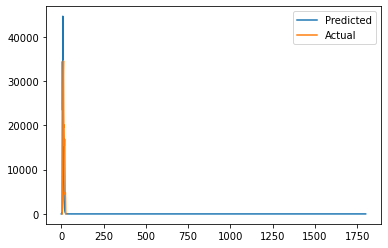

In [30]:
metrics_and_plot(df, optimal_parameters)[1]

In [20]:
df

(23,)

array([1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.98370582e-296, 6.78713153e-296, 4.61403363e-296])

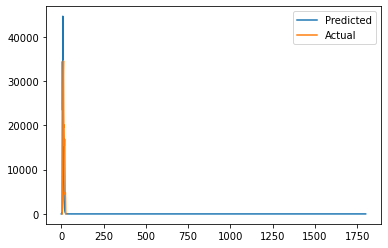

In [24]:
df = obsData

# mu, alpha, beta, I0
# for sim, 'a' for sim, 'lam_m' for sim,  fractions with different exposure history?
optimal_parameters =  [0.9092460318123954, 0.001802514427547769,
                       904.9228853554217, 0.2882931865945249]
predictions = metrics_and_plot(df, optimal_parameters)[1]
predictions

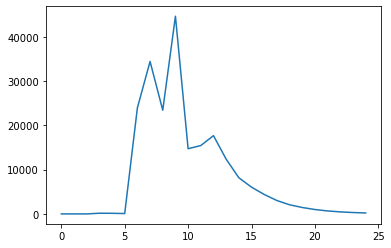

In [23]:
plt.plot(predictions[:25])

(0, array([1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       9.98370582e-296, 6.78713153e-296, 4.61403363e-296]))


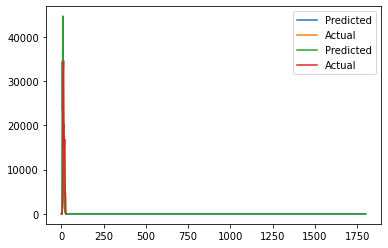

In [12]:
predictions = []
phase = [1]
for i in range(len(phase)):    
    df = obsData
    optimal_parameters =  [0.9092460318123954,
  0.001802514427547769,
  904.9228853554217,
  0.2882931865945249] #mh(df)

    predictions.extend(metrics_and_plot(df, optimal_parameters)[1])

#         intial_data = new_start_point
    print(metrics_and_plot(df, optimal_parameters))

(0,
 array([1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        9.98370582e-296, 6.78713153e-296, 4.61403363e-296]))

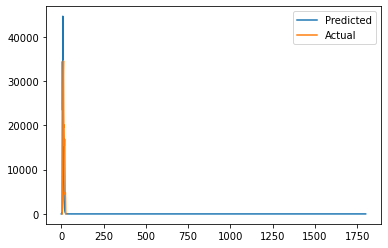

In [15]:
metrics_and_plot(df, optimal_parameters)

In [33]:
optimal_parameters # [0.9092460318123954,
 # 0.001802514427547769,
 # 904.9228853554217,
 # 0.2882931865945249]#

[0.9092460318123954,
 0.001802514427547769,
 904.9228853554217,
 0.2882931865945249]

In [34]:
r2_score(obsData, predictions[:len(obsData)])

0.34477224944818474

In [35]:
35/44

0.7954545454545454

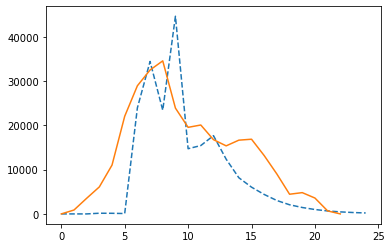

In [46]:
plt.plot(predictions[:25], ls='--')
plt.plot(list(obsData))

In [47]:
predict = predictions[:25] # ??
ma_pr = max(predict)
ind_pr = predict.index(ma_pr)

obsData = list(obsData)

ma_data = max(obsData)
ind_data = obsData.index(ma_data)

In [48]:
(ind_data-ind_pr, ma_data/ma_pr)

(-1, 0.7742680583233457)

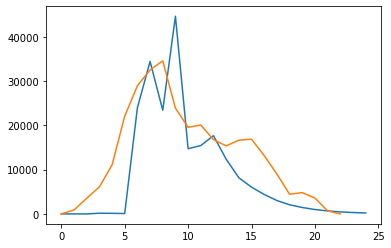

In [49]:
plt.plot(predict)
plt.plot(obsData)

In [ ]:
Нужно уточнить про данные!!!!

# ABC

In [50]:
def model(theta, T):
    T = len(obsData)
    mu, alpha, beta, I0 = theta

    pop = 4581854.0

    m = BRModel([[6.528]], pop, mu, 'total', '', '')
    exposed_list, lam_list, a = [I0], [beta], [alpha]
    m.set_attributes()
    m.init_simul_params(exposed_list, lam_list, a)
    m.set_attributes()

    Y, population_immunity, rho, r0, rt = m.make_simulation()
    Y = Y[0][0]

    scop = float('-inf')
    out = Y[:T]

    ma = max(obsData)
    prMVal = max(Y[:T])
    #prMInd = list(Y).index(prMVal)

    if prMVal>0:
        s = prMVal/ma
        Y/=s
    
    # for j in range(200):
    #     R = max(r2_score(obsData,Y[j:j+T]), scop)
    #     if R!=scop:
    #         scop = R
    #         out = Y[j:j+T]

    return out

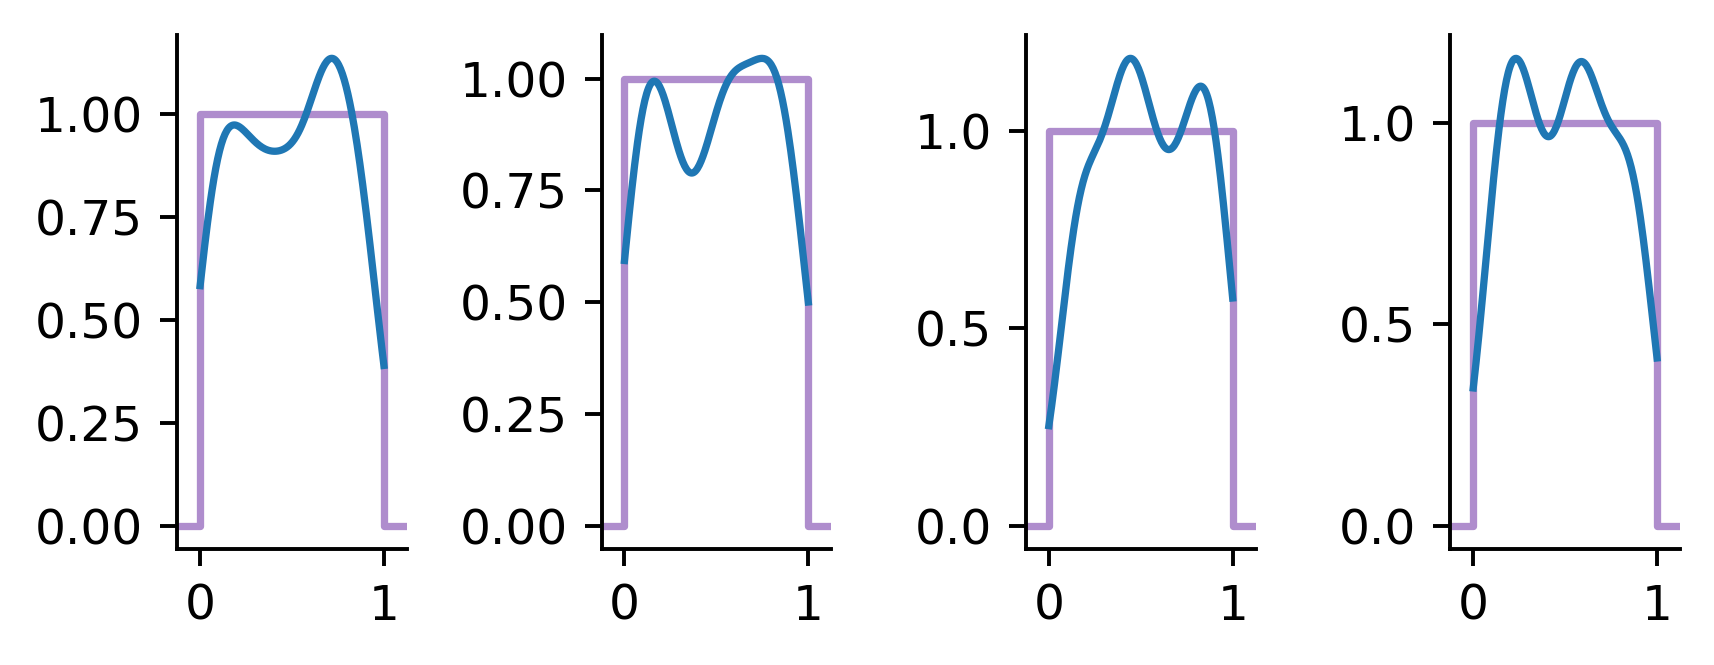

  0%|          | 0/6 [00:00<?, ?it/s]

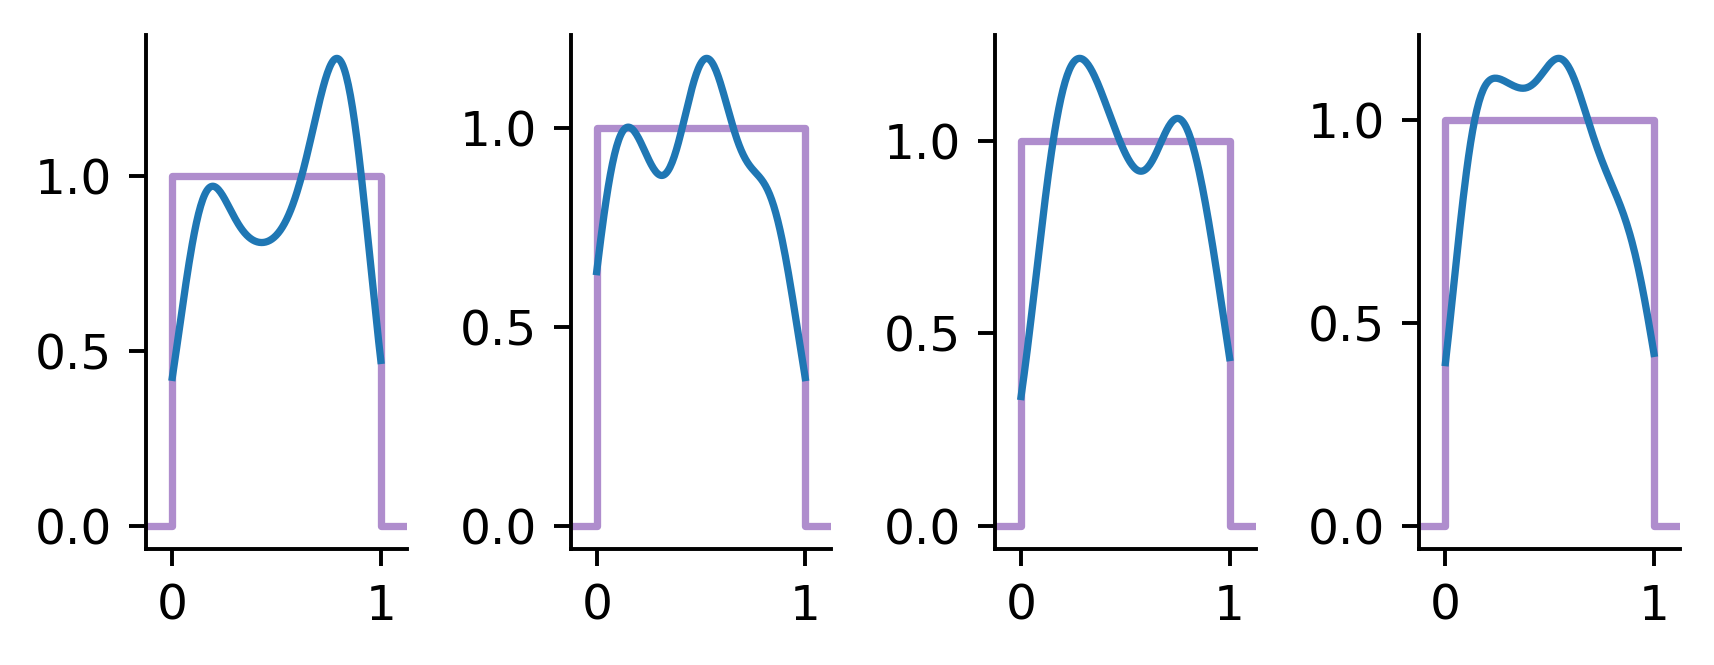

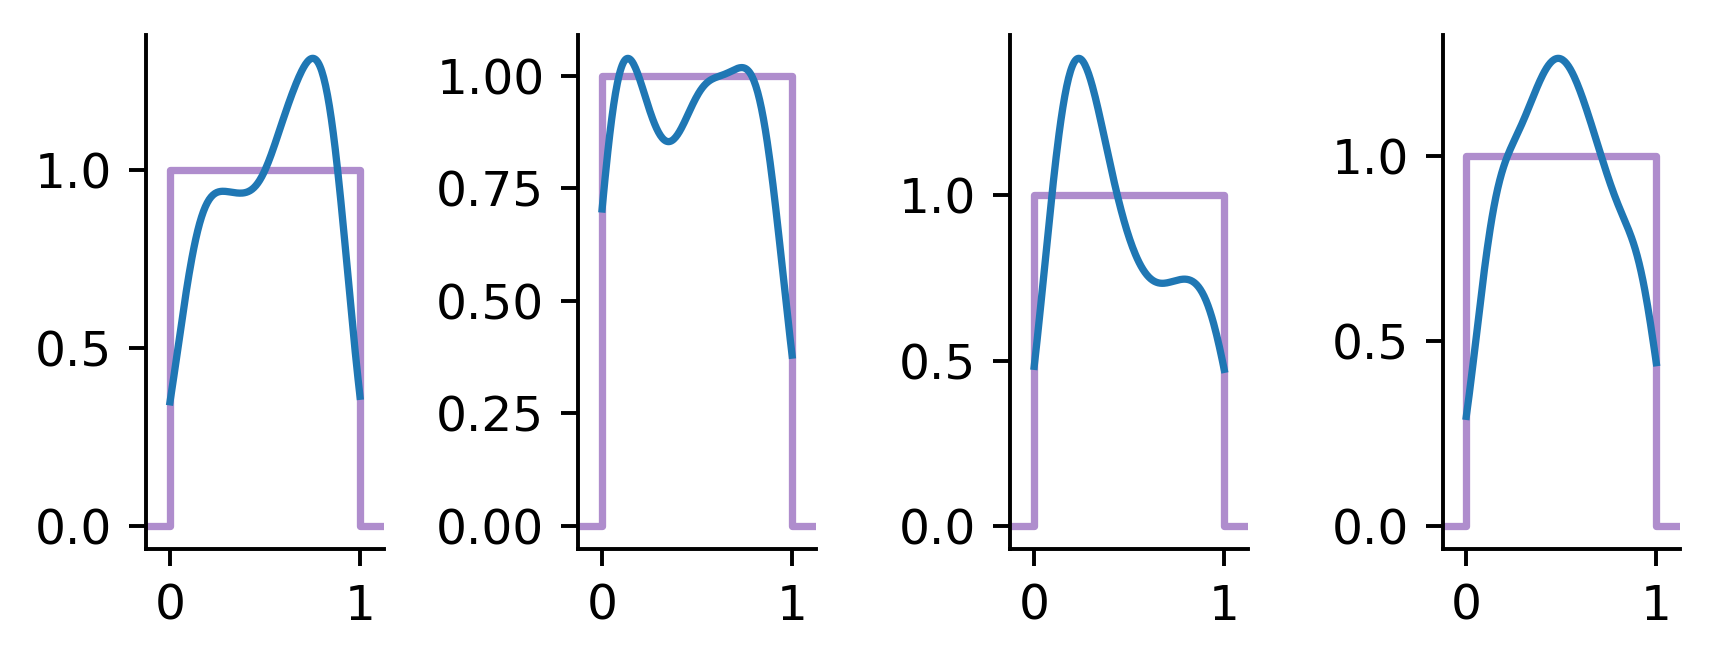

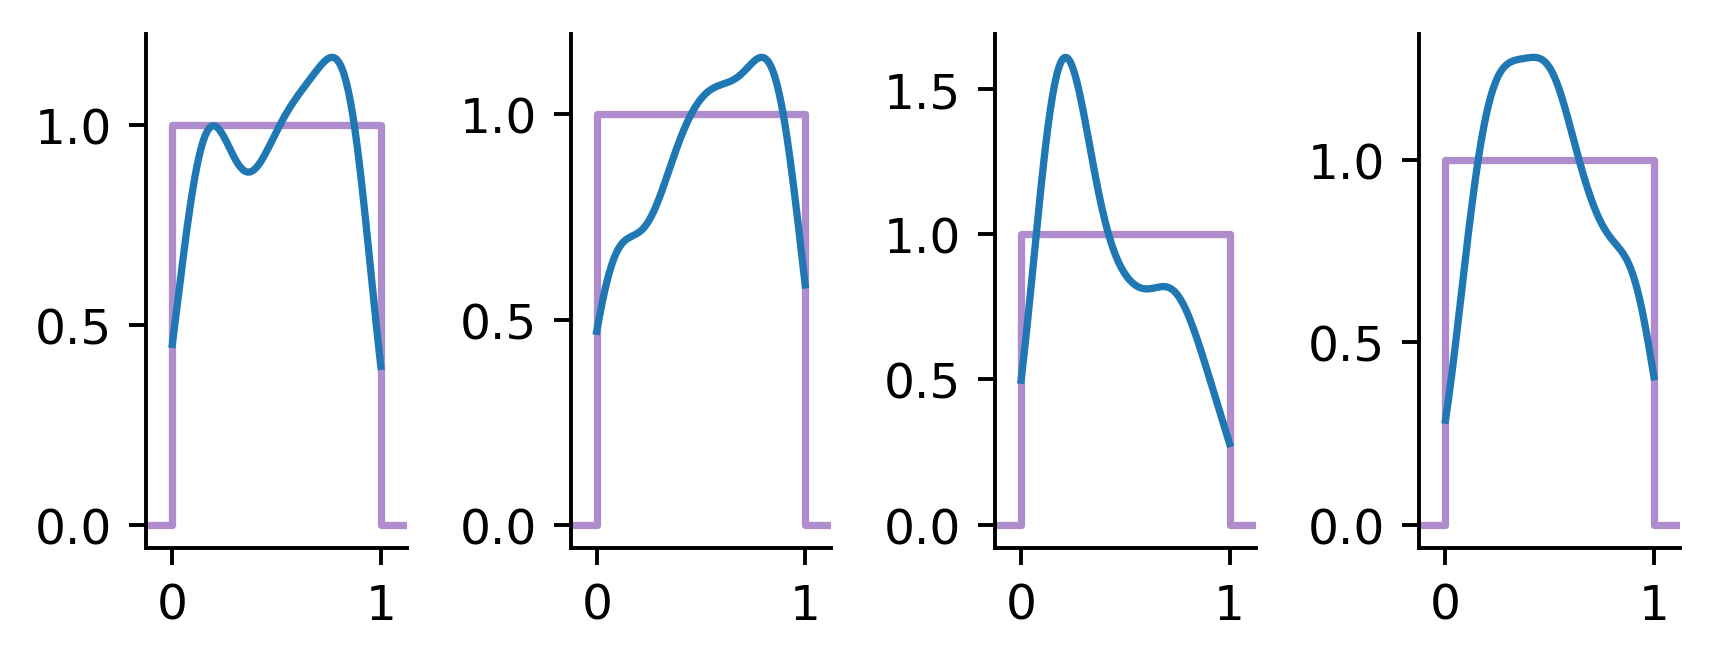

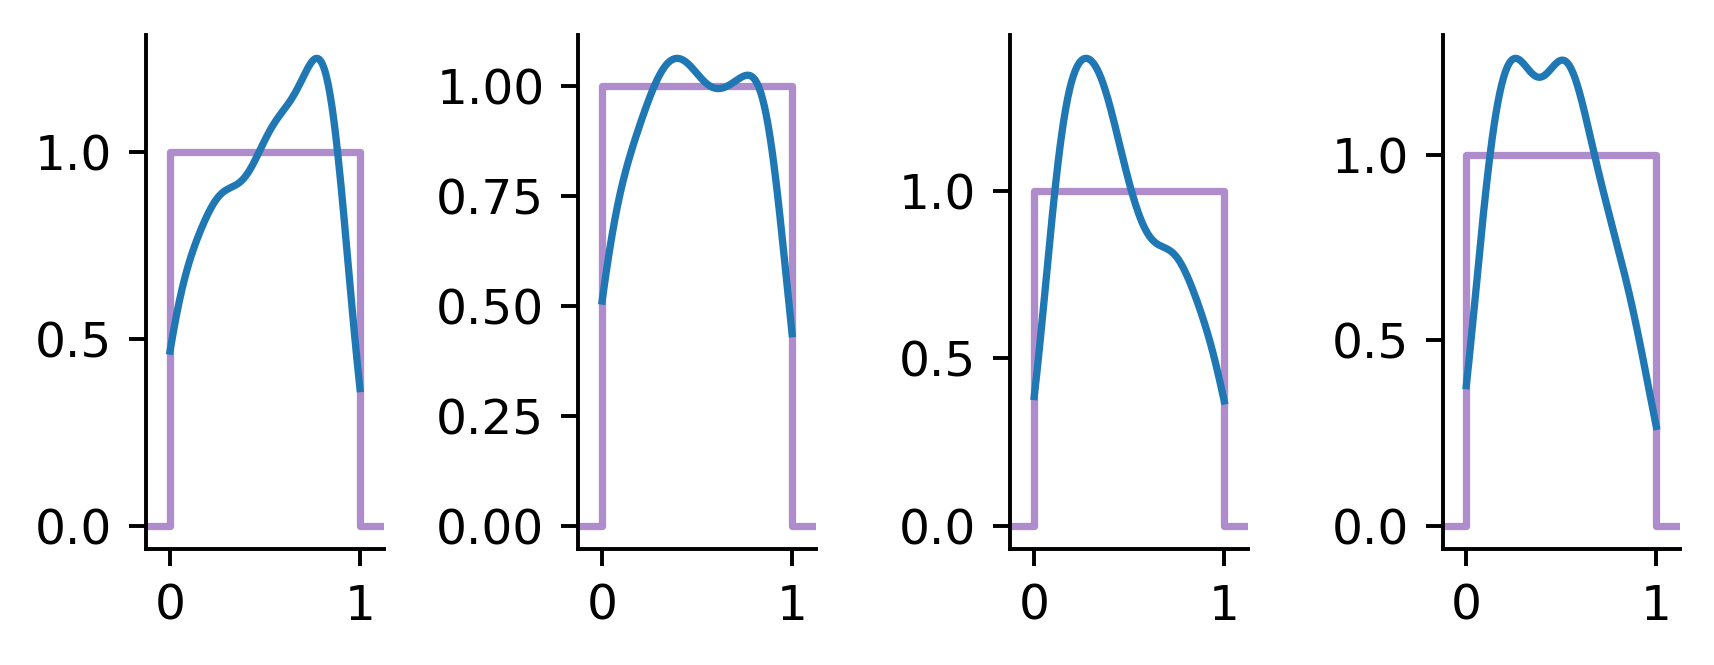

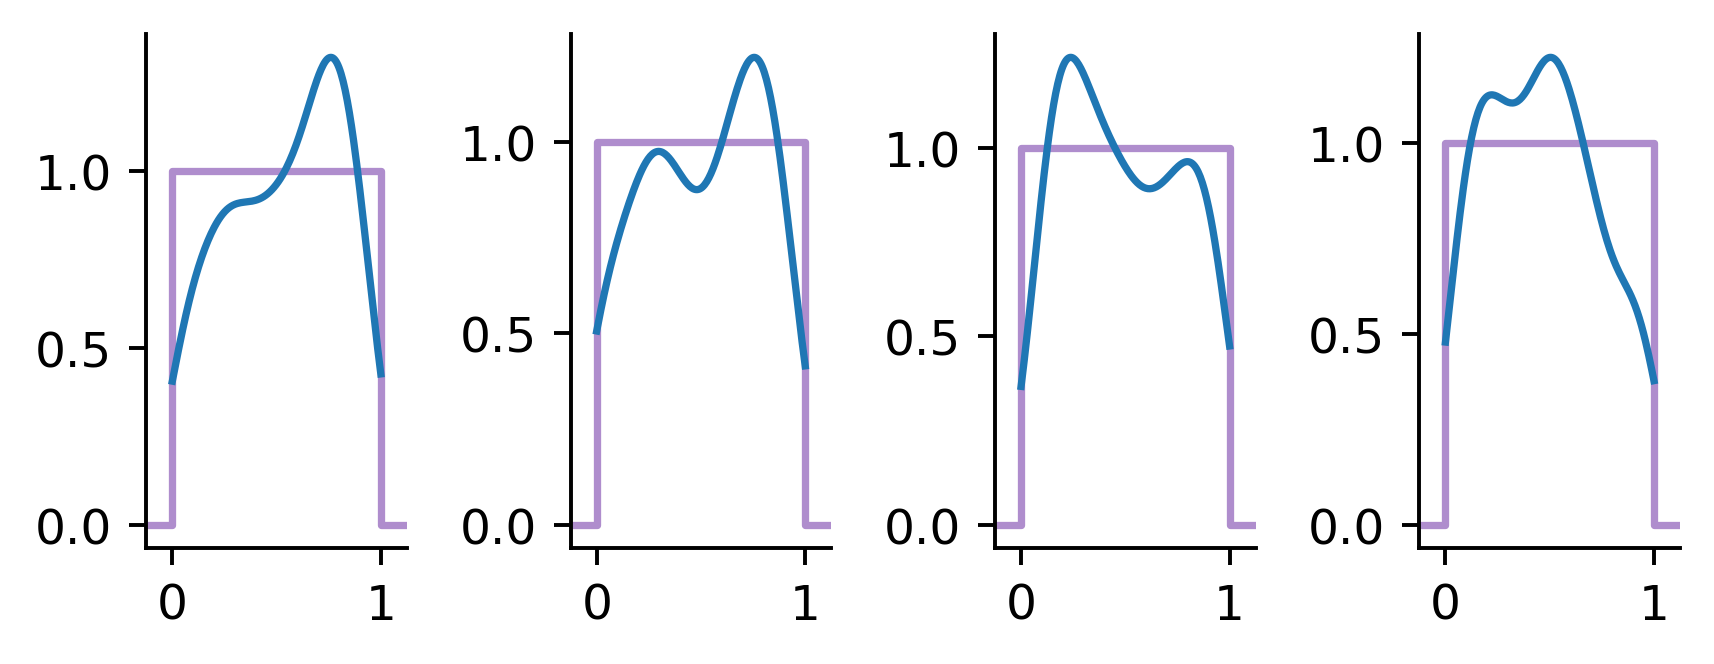

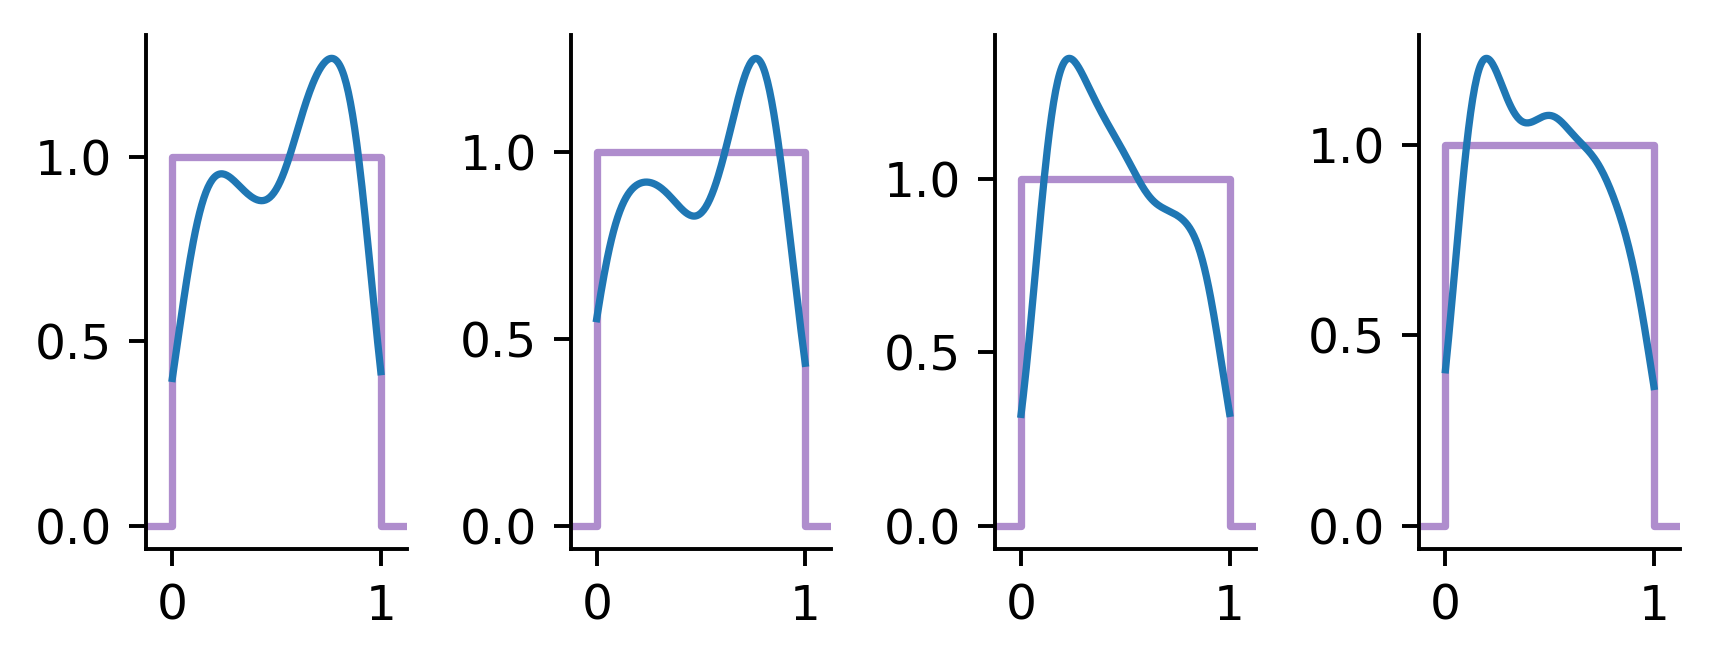

Posterior mean of mu:     0.5240174545517665
Posterior mean of alpha:  0.5065241096008538
Posterior mean of beta:   0.468299272523675
Posterior mean of I0:     0.47350588504450947
R^2:                      -2.1681011372535344


In [51]:
#                                      mu,   alpha,   beta,  exposed
prior = abc.IndependentUniformPrior([(0, 1), (0, 1), (0, 1), (0,1)])

# Fit the model to the data using ABC
numIters = 6  # The number of SMC iterations to perform
popSize = 250  # The population size of the SMC method

    
simulator = lambda theta: model(theta, len(obsData))
fit = abc.smc(numIters, popSize, obsData, simulator, prior, 
              showProgressBar=True, numProcs=6, plotProgress=True)

theta = (np.sum(fit.samples[:, 0] * fit.weights), 
         np.sum(fit.samples[:, 1] * fit.weights), 
         np.sum(fit.samples[:, 2] * fit.weights), 
         np.sum(fit.samples[:, 3] * fit.weights))

predictions = simulator(theta)

print("Posterior mean of mu:    ", theta[0])
print("Posterior mean of alpha: ", theta[1])
print("Posterior mean of beta:  ", theta[2])
print("Posterior mean of I0:    ", theta[3])
print("R^2:                     ", r2_score(obsData, predictions))

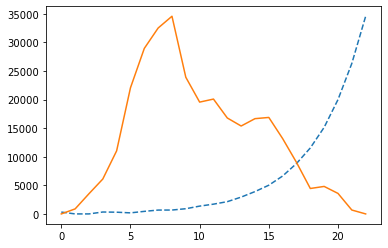

In [53]:
plt.plot(predictions, ls='--')
plt.plot(obsData)